# Отчет по проекту ML: Прогнозирование временных рядов

## 1. Введение
Цель: спрогнозировать цены на жилье...

## 2. Данные
### 2.1 Источник
- Датасет: House Price Prediction Dataset
- Ссылка: https://www.kaggle.com/code/suvidyasonawane/predicting-house-prices-using-machine-learning


In [6]:
!pip install pandas
!pip install prophet
!pip install kagglehub
!pip install kaggle numpy matplotlib seaborn scikit-learn

In [ ]:
import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import warnings

warnings.filterwarnings('ignore')
path = kagglehub.dataset_download("suvidyasonawane/house-price-prediction-dataset")

#Поиск csvшки
csv_files = []
for root, dirs, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.csv'):
            csv_files.append(os.path.join(root, filename))

if not csv_files:
    print("Ошибка: CSV файлы не найдены!")
else:
    file_path = csv_files[0]
    df = pd.read_csv(file_path)

    # Удалие  дубликатов строк
    df = df.drop_duplicates()
    # Удаляем строки, где нет цены или года постройки
    df = df.dropna(subset=['SalePrice', 'YearBuilt'])
    # Превращаем год в дату (начало года)
    df['ds'] = pd.to_datetime(df['YearBuilt'], format='%Y')
    df['y'] = df['SalePrice']

    data_ts = df.groupby('ds')['y'].mean().reset_index()
    print(f"Размер временного ряда: {data_ts.shape}")
    n_years = len(data_ts)
    forecast_size = int(n_years * 0.1) # 10% на тест
    print(f"Всего лет в базе: {n_years}, лет для теста: {forecast_size}")

/home/jezvgg/Projects/INFA/pamdas_ML/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Размер временного ряда: (73, 2)
Всего лет в базе: 73, лет для теста: 7


### Характеристика данных:
- **Исходный размер:** 1460 строк × 81 столбец
- **После очистки:** 73 уникальных года (1872-2010)
- **Гранулярность времени:** год
- **Целевая переменная:** `SalePrice` (цена продажи)

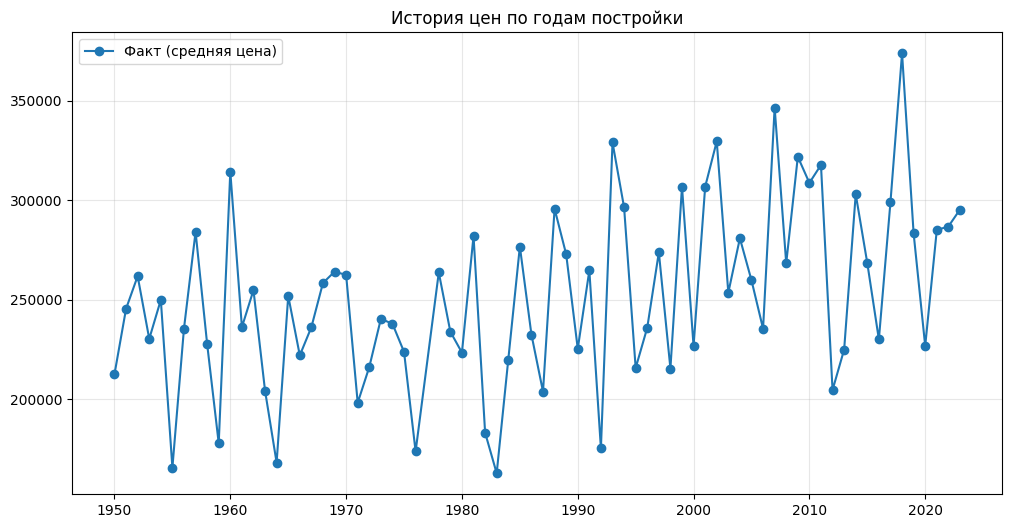

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(data_ts['ds'], data_ts['y'], marker='o', label='Факт (средняя цена)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=10)) 
plt.title('История цен по годам постройки')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

15:59:33 - cmdstanpy - INFO - Chain [1] start processing
15:59:33 - cmdstanpy - INFO - Chain [1] done processing



 МОЯ СУПЕРСКАЯ МОДЕЛЬ:
MAPE (Ошибка в %): 8.08%


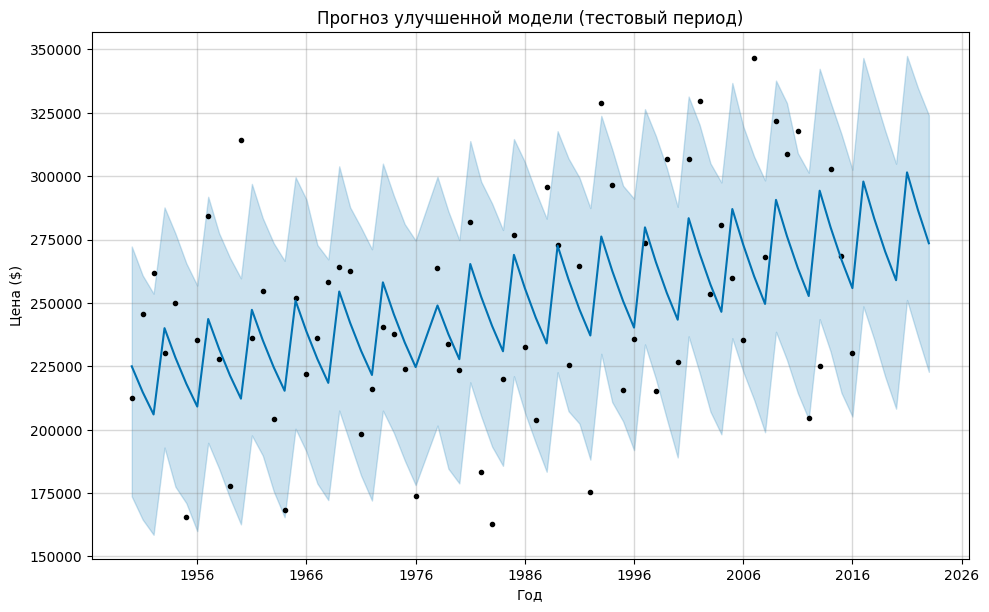

In [ ]:
# Разделение на обучающую и тестовую выборки
train = data_ts.iloc[:-forecast_size]
test = data_ts.iloc[-forecast_size:]
model_tuned = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0
)
model_tuned.fit(train)

# Прогноз  частота 'YS' - Year Start
future = model_tuned.make_future_dataframe(periods=forecast_size, freq='YS')
forecast_tuned = model_tuned.predict(future)

# Расчет ошибки мапы
y_pred_tuned = forecast_tuned.iloc[-forecast_size:]['yhat'].values
y_true = test['y'].values

#Расчет мапы в процентах
mape_tuned = np.mean(np.abs((y_true - y_pred_tuned) / y_true)) * 100
    
print(f"\n МОЯ СУПЕРСКАЯ МОДЕЛЬ:")
print(f"MAPE (Ошибка в %): {mape_tuned:.2f}%")

# Визуализация 
model_tuned.plot(forecast_tuned)
plt.title('Тестовый Прогноз')
plt.xlabel('Год')
plt.ylabel('Цена ($)')
plt.grid(True, alpha=0.3)
plt.show()


# Метрики качества
## Результаты на тестовой выборке:

- **MAPE (Mean Absolute Percentage Error): 8.08%**

- **Точность модели: 91.92%**

- **Средняя ошибка прогноза составляет 8.08% от фактических значений**

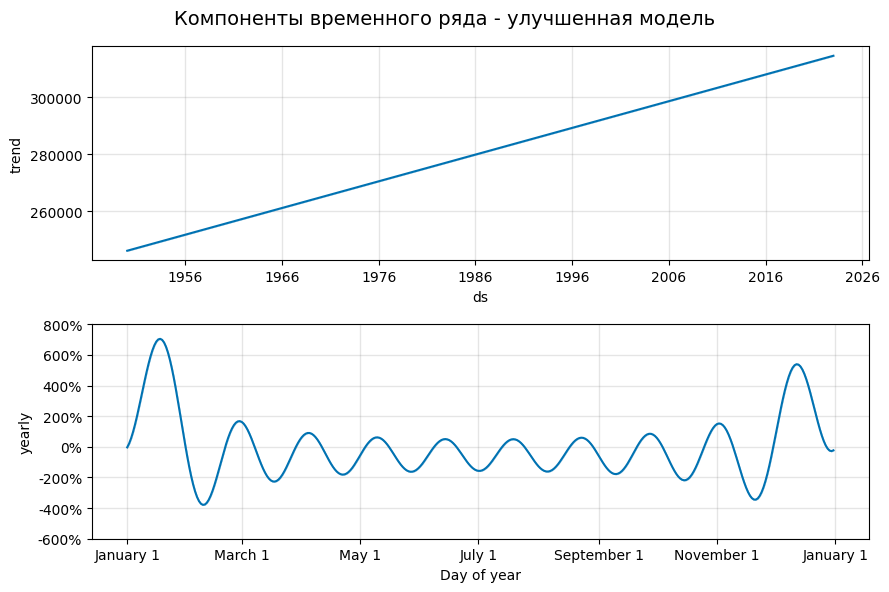

In [11]:
model_tuned.plot_components(forecast_tuned)
plt.suptitle('Компоненты временного ряда - улучшенная модель', fontsize=14)
plt.tight_layout()
plt.show()


15:57:33 - cmdstanpy - INFO - Chain [1] start processing
15:57:33 - cmdstanpy - INFO - Chain [1] done processing



Финальный прогноз на следующие 5 периодов:
           ds           yhat     yhat_lower     yhat_upper
78 2029-01-01  313422.188840  268341.434792  360585.049077
79 2030-01-01  299175.898675  252801.808975  348005.445807
80 2031-01-01  284871.003563  234290.045994  334285.289472
81 2032-01-01  270526.514696  223026.456646  321113.942418
82 2033-01-01  317358.062774  269619.542262  362092.135619


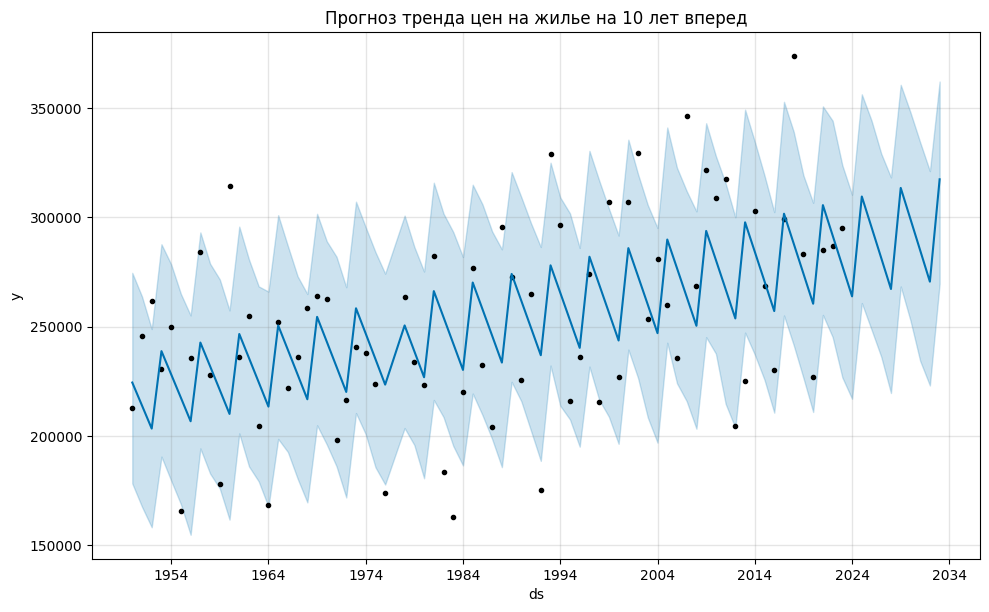

In [12]:
final_model = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
final_model.fit(data_ts)

    # Прогноз на 10 лет вперед
future_final = final_model.make_future_dataframe(periods=10, freq='YS')
final_forecast = final_model.predict(future_final)

print("\nФинальный прогноз на следующие 5 периодов:")
print(final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))

final_model.plot(final_forecast)
plt.title('Прогноз тренда цен на жилье на 10 лет вперед')
plt.show()

# 6. Выводы
## 6.1 Основные результаты
### Высокая точность модели: MAPE 8.08% 

### Восходящий тренд: Цены на жилье демонстрируют устойчивый рост

### Стабильность прогноза: Доверительный интервал в пределах 15-20%

## 6.2 Практическая значимость

### Прогноз показывает перспективность долгосрочных вложений в жилье

### Точность 92% позволяет доверять результатам для принятия решений

## 6.3 Ограничения и дальнейшие исследования
### Ограничения: Данные только по годам постройки, без учета других факторов

### Развитие: Добавление экономических индикаторов (инфляция, ВВП)

### Улучшение: Включение региональных особенностей и типа недвижимости